Intention of this notebook is to see what performance can be achieved on the primary sequence or sequence representation of the mutant xor wildtype sequence, which should not be enough for accurate dTm prediction.

For the current nomenclature refer to the model names in the brackets.


## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import seaborn as sns
import pylab

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/cnn_rep_sampler_T1626/"
data_primary_seq_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Sanity_Checks/"

y_target_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/own_baseline_xgboost_T1626/" + "y_label_own_baseline_xgboost_T1626.pkl"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_diff_01_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_diff_02_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"
X_seq_diff_03_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_03.csv"

X_raw_seq_loc_mut = data_primary_seq_folder_loc+"T1626_X_mut.npy"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_diff_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_diff_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_seq_diff_03_loc))
print("\t",os.path.isfile(X_raw_seq_loc_mut))

Folders: 
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

## Notebook Setup Local Runtime

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import RepeatedKFold
import time
import datetime

In [0]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

In [0]:
#Set up file paths:
data_folder_loc = "Users/Whatever/Desktop/Google_Colab_Local/cnn_rep_sampler_T1626/"
data_primary_seq_folder_loc = "Users/Whatever/Desktop/Google_Colab_Local/sequence_sampler_T1626/"
model_folder_loc = "Users/Whatever/Desktop/Google_Colab_Local/Sanity_Checks/"

y_target_loc = "Users/Whatever/Desktop/Google_Colab_Local/own_baseline_xgboost_T1626/" + "y_label_own_baseline_xgboost_T1626.pkl"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_diff_01_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_diff_02_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"
X_seq_diff_03_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_03.csv"

X_raw_seq_loc_mut_loc = data_primary_seq_folder_loc+"T1626_X_mut.npy"
X_raw_seq_loc_wt_loc = data_primary_seq_folder_loc+"T1626_X_wild.npy"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(data_primary_seq_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_diff_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_diff_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_seq_diff_03_loc))
print("\t",os.path.isfile(X_raw_seq_loc_mut_loc))
print("\t",os.path.isfile(X_raw_seq_loc_wt_loc))

Folders: 
	 False
	 False
	 False
Files: 
	 False
	 False
	 False
	 False
	 False
	 False
	 False
	 False
	 False


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_pickle(y_target_loc) 

X_raw_mut =  pd.DataFrame(np.load(X_raw_seq_loc_mut_loc))
X_raw_wt =  pd.DataFrame(np.load(X_raw_seq_loc_wt_loc))

X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_diff_01 = pd.read_csv(X_seq_diff_01_loc, index_col=0)
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_diff_02 = pd.read_csv(X_seq_diff_02_loc, index_col=0)
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_diff_03 = pd.read_csv(X_seq_diff_03_loc, index_col=0)

In [0]:
X_raw_diff = (X_raw_wt-X_raw_mut) > 1
X_raw_diff = X_raw_diff.astype("int32") #1 where mutation took place

X_raw_all = pd.concat([X_raw_wt, X_raw_mut, X_raw_diff], axis=1) #simple concatenated the features
X_raw_all.head()

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
1,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
2,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
3,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
4,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0


In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_diff_01_02_03 = pd.concat([X_seq_diff_01, X_seq_diff_02, X_seq_diff_03], axis=1)

In [0]:
mut_columns = list(set(list(filter(lambda x: "mut_rep" in x, X_seq_all_01_02_03.columns)))) #multiple colums named the same :(, weird selection required
X_seq_mut_01_02_03 = X_seq_all_01_02_03[mut_columns]

In [0]:
wt_columns = list(set(list(filter(lambda x: "wt_rep" in x, X_seq_all_01_02_03.columns)))) #multiple colums named the same :(, weird selection required
X_seq_wt_01_02_03 = X_seq_all_01_02_03[wt_columns]

In [0]:
mut_columns = list(set(list(filter(lambda x: "mut_rep" in x, X_seq_all_01.columns)))) #multiple colums named the same :(, weird selection required
X_seq_mut_01 = X_seq_all_01[mut_columns]

In [0]:
wt_columns = list(set(list(filter(lambda x: "wt_rep" in x, X_seq_all_01.columns)))) #multiple colums named the same :(, weird selection required
X_seq_wt_01 = X_seq_all_01[wt_columns]

In [0]:
print(X_seq_mut_01.shape)
X_seq_mut_01.head()

(1626, 512)


,mut_rep_380,mut_rep_42,mut_rep_248,mut_rep_245,mut_rep_25,mut_rep_247,mut_rep_447,mut_rep_54,mut_rep_275,mut_rep_224,...,mut_rep_485,mut_rep_8,mut_rep_382,mut_rep_63,mut_rep_322,mut_rep_372,mut_rep_416,mut_rep_429,mut_rep_484,mut_rep_381
Mutation,,,,,,,,,,,,,,,,,,,,,
1AKY@A@I213F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043451
1AKY@A@N169D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107343
1AKY@A@Q48E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077438
1AKY@A@T110H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109347
1AKY@A@T77H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062871


In [0]:
print(X_raw_mut.shape)
X_raw_mut.head()

(1626, 650)


,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
1,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
2,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
3,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0
4,16,16,4,16,8,15,11,18,10,8,...,0,0,0,0,0,0,0,0,0,0


## Supplementary functions


### N-Trial nested K-Fold Crossvalidation Funtion 

In [0]:
def n_trial_nested_k_fold_crossvalidation(data_x, data_y, num_trials=7, eval_metric="mae", scale_label=False, inner_fold=3, outer_fold=5, bayes_init_points=15, bayes_iterations=10, bayes_acquisition_function='ei', repeated_k_fold_seed=42375):  
  print("Trials: ", num_trials)
  print("Evaluation metric: ", eval_metric)
  print("Inner folds: ", inner_fold)
  print("Outer folds: ", outer_fold)
  print("Bayesian init points: ", bayes_init_points)
  print("Bayesian iterations: ", bayes_iterations)
  print("Bayes acquisition function: ", bayes_acquisition_function)

  # Variable for xgb_evalutate, unfortunately cannot be a direct argument
  bayesian_training_data = None
  # Supplementary function for hyperparameter tuning. Corresponds in essense to inner cross validation.
  def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, eta):
      params = {'eval_metric': eval_metric,
                'objective':'reg:linear',
                'tree_method': 'gpu_hist',
                'max_depth': int(max_depth),
                'eta': eta,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'subsample': subsample}
      # This corresponds to the inner cross validation cycle for hyperparameter tuning:
      cv_result = xgb.cv(params, bayesian_training_data, num_boost_round=100, nfold=inner_fold)    
      # Bayesian optimization only knows how to maximize, not minimize, thus negate score:
      return -1.0 * cv_result['test-mae-mean'].iloc[-1]
    
  # Bounds for the bayesian optimization
  bay_bounds={'eta': (0.01, 0.3),
              'max_depth': (5, 10), 
              'gamma': (0.0, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'subsample': (0.7, 1.0)}
    
  #saves result for each outer cross val
  scores_mae = [] 
  scores_rmse = []
  best_parameters = []

  total_fold_counter = 0
  rkf = RepeatedKFold(n_splits=outer_fold, n_repeats=num_trials, random_state=repeated_k_fold_seed)
  # Main loop for trials and outer outer cross_val
  for train_index, test_index in rkf.split(data_x):
    #Measure runtime
    start_time = time.time()
    
    # Print current status
    print("\nTrial number: ", (total_fold_counter//outer_fold)+1)
    print("Fold number: ", (total_fold_counter%outer_fold)+1)
    total_fold_counter += 1
    
    # Select current train and test data
    X_train, X_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
    
    # Scale target label, if requested
    standard_scaler = preprocessing.StandardScaler()
    if scale_label:
      y_train = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage
    
    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # Bayesian optimize in 5 fold cross validation
    xgb_bo = BayesianOptimization(f=xgb_evaluate, 
                                  pbounds=bay_bounds,
                                  random_state=((total_fold_counter*repeated_k_fold_seed)%1000)) #create deterministic seed from outer_fold, num_trials and repeated_k_fold_seed
    bayesian_training_data = dtrain
    xgb_bo.maximize(init_points=bayes_init_points, n_iter=bayes_iterations, acq=bayes_acquisition_function) #default: 20,20,'ei'
    
    # Extract optimal parameters
    params_opt = xgb_bo.max['params']
    best_parameters.append(params_opt) #save best parameters
    params_opt['max_depth'] = int(params_opt['max_depth'])
    params_opt['eval_metric'] = eval_metric
    params_opt['objective'] = 'reg:linear'
    params_opt['tree_method'] = 'gpu_hist'
    
    # Train a new model with the best parameters from the search
    model = xgb.train(params_opt, dtrain, num_boost_round=1000)

    # Predict on testing set
    y_pred = model.predict(dtest)
    if scale_label:
      y_pred = standard_scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Report testing and training scores
    scores_mae.append(mean_absolute_error(y_test, y_pred))
    scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: ", scores_mae[-1], " RMSE: ",scores_rmse[-1], " Runtime: ", str(datetime.timedelta(seconds=(time.time()-start_time))))
  
  print()
  results = pd.DataFrame(best_parameters)
  results["scores_mae"] = scores_mae
  results["scores_rmse"] = scores_rmse
  return results

### Other supplementary functions

In [0]:
def plot_results_bar_err(results_df, std_df, title, saveloc, fig_size=(7,6), fig_lim=(2,6)):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(yerr=std_df, ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7, error_kw=dict(ecolor='dimgrey', lw=1.5, capsize=4, capthick=1.5))
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

## Evaluate different models (based on source data)

### Model mut 01:(M1)

In [0]:
model_mut_only_01_results = n_trial_nested_k_fold_crossvalidation(X_seq_mut_01.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.429    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.547    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.603    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.59     |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.618    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.383    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.464    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.475    |  0.8363   |  0.1

In [0]:
model_mut_only_01_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.685944,0.060573,0.433094,7.971429,0.853267,3.395267,4.565436
std,0.121046,0.032640,0.281850,1.070616,0.087138,0.143844,0.203050
min,0.514375,0.012632,0.053701,5.000000,0.700699,3.064672,3.966728
25%,0.586535,0.038415,0.243991,7.500000,0.781476,3.307543,4.440094
50%,0.640035,0.056826,0.354903,8.000000,0.851849,3.404367,4.523748
75%,0.784251,0.077492,0.644055,9.000000,0.921401,3.456644,4.710830
max,0.990882,0.154447,0.979590,9.000000,0.988668,3.782105,5.021891


In [0]:
model_mut_only_01_results.to_csv(model_folder_loc+"results_mut_only_01_xgboost_T1626.csv")

### Model mut 01 02 03: (M13)

In [0]:
model_mut_only_01_02_03_results = n_trial_nested_k_fold_crossvalidation(X_seq_mut_01_02_03.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.21     |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.331    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.328    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.429    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.271    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.174    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.237    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.234    |  0.8363   |  0.1

In [0]:
model_mut_only_01_02_03_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.702566,0.071910,0.457496,8.085714,0.861482,3.073905,4.231517
std,0.115890,0.037202,0.272845,0.950895,0.082006,0.142762,0.219870
min,0.550706,0.021728,0.075318,5.000000,0.733678,2.764910,3.709977
25%,0.596812,0.044341,0.278652,8.000000,0.804292,2.984483,4.072620
50%,0.706322,0.063112,0.414122,8.000000,0.851849,3.064335,4.226377
75%,0.821043,0.083311,0.638675,9.000000,0.916207,3.174868,4.360049
max,0.990882,0.162371,0.979590,9.000000,1.000000,3.446777,4.740922


In [0]:
model_mut_only_01_02_03_results.to_csv(model_folder_loc+"results_mut_only_01_02_03_xgboost_T1626.csv")

### Model raw mut: (raw_M)

In [0]:
model_raw_mut_results = n_trial_nested_k_fold_crossvalidation(X_raw_mut.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.485    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.486    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.491    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.602    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.527    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.457    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.489    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.471    |  0.8363   |  0.1

In [0]:
model_raw_mut_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.674881,0.164882,0.431205,7.257143,0.833557,3.471985,4.890583
std,0.143820,0.080517,0.219168,1.291211,0.087825,0.181786,0.257689
min,0.500000,0.044341,0.000000,5.000000,0.700000,3.155911,4.327023
25%,0.553162,0.086556,0.307466,6.000000,0.770470,3.330800,4.742520
50%,0.632278,0.156939,0.412826,7.000000,0.846381,3.483158,4.895848
75%,0.763557,0.223672,0.606461,8.000000,0.889309,3.616721,5.077922
max,1.000000,0.300000,0.999237,9.000000,1.000000,3.923556,5.438797


In [0]:
model_raw_mut_results.to_csv(model_folder_loc+"results_raw_mut_xgboost_T1626.csv")

### Model wt_01: (W1)

In [0]:
model_wt_only_01_results = n_trial_nested_k_fold_crossvalidation(X_seq_wt_01.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.633    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.684    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.681    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.651    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.679    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.671    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.689    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.681    |  0.8363   |  0.1

In [0]:
model_wt_only_01_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.710072,0.018329,0.585440,7.342857,0.837368,3.646609,4.885219
std,0.135660,0.006480,0.318871,1.877778,0.119567,0.115320,0.189213
min,0.500000,0.010000,0.000000,5.000000,0.700000,3.416292,4.424134
25%,0.545844,0.012632,0.197091,5.000000,0.720542,3.587769,4.764002
50%,0.767527,0.016878,0.650924,8.000000,0.840267,3.653250,4.886201
75%,0.817321,0.024985,0.866138,9.000000,0.961339,3.731110,4.991977
max,0.869604,0.029535,1.000000,10.000000,1.000000,3.934203,5.263230


In [0]:
model_wt_only_01_results.to_csv(model_folder_loc+"results_wt_only_01_xgboost_T1626.csv")

### Model wt_01_02_03: (W13)

In [0]:
model_wt_only_01_02_03_results = n_trial_nested_k_fold_crossvalidation(X_seq_wt_01_02_03.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.641    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.696    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.704    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.631    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.671    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.675    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.673    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.671    |  0.8363   |  0.1

In [0]:
model_wt_only_01_02_03_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.711302,0.018503,0.580121,7.000000,0.864372,3.643491,4.881846
std,0.146332,0.006557,0.329634,1.862951,0.118777,0.113508,0.185893
min,0.500000,0.010000,0.000000,5.000000,0.700699,3.412315,4.424834
25%,0.548123,0.012632,0.197091,5.000000,0.730667,3.587026,4.764875
50%,0.767527,0.016878,0.650924,7.000000,0.931392,3.653714,4.887886
75%,0.817321,0.024985,0.877458,9.000000,0.961675,3.711281,5.007523
max,1.000000,0.029535,1.000000,10.000000,1.000000,3.931585,5.271788


In [0]:
model_wt_only_01_02_03_results.to_csv(model_folder_loc+"results_wt_only_01_02_03_xgboost_T1626.csv")

### Model raw wt: (raw_W)

In [0]:
model_raw_wt_results = n_trial_nested_k_fold_crossvalidation(X_raw_wt.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.641    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.673    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.68     |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.644    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.67     |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.667    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.673    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.674    |  0.8363   |  0.1

In [0]:
model_raw_wt_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.726005,0.020248,0.604019,6.971429,0.859002,3.647965,4.887596
std,0.128119,0.006411,0.300896,1.757098,0.116976,0.111322,0.187392
min,0.500000,0.010000,0.033418,5.000000,0.700699,3.415486,4.423666
25%,0.601538,0.015863,0.402157,5.000000,0.730667,3.599639,4.771160
50%,0.779976,0.017805,0.650924,7.000000,0.931392,3.652680,4.891353
75%,0.832081,0.027898,0.866138,9.000000,0.961675,3.710575,5.015459
max,0.908561,0.029535,1.000000,10.000000,1.000000,3.931689,5.268178


In [0]:
model_raw_wt_results.to_csv(model_folder_loc+"results_raw_wt_xgboost_T1626.csv")

### Model raw all: (raw_A)

In [0]:
model_raw_all_results = n_trial_nested_k_fold_crossvalidation(X_raw_all.values, y_label.values)

Trials:  7
Evaluation metric:  mae
Inner folds:  3
Outer folds:  5
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei

Trial number:  1
Fold number:  1
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.504    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.59     |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.534    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.605    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.594    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.51     |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.521    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.522    |  0.8363   |  0.1

In [0]:
model_raw_all_results.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.718172,0.119345,0.563751,8.085714,0.814747,3.490437,4.877646
std,0.161231,0.098071,0.288561,1.094678,0.101299,0.169712,0.264067
min,0.500000,0.012632,0.071504,5.000000,0.700000,3.131487,4.304341
25%,0.566703,0.037435,0.324627,8.000000,0.711389,3.399231,4.711040
50%,0.663337,0.084040,0.638675,8.000000,0.816699,3.507033,4.874110
75%,0.847584,0.186044,0.801432,9.000000,0.914156,3.597749,5.065564
max,1.000000,0.300000,1.000000,9.000000,0.970161,3.928968,5.453671


In [0]:
model_raw_all_results.to_csv(model_folder_loc+"results_raw_all_xgboost_T1626.csv")

##Results


In [0]:
model = ["raw_W","raw_M","raw_A","W1","M1","W13","M13"]
value = [[3.647965,4.887596],
         [3.471985,4.890583],
         [3.490437,4.877646],
         [3.646609,4.885219],
         [3.395267,4.565436],
         [3.643491,4.881846],
         [3.073905,4.231517]]
std = [[0.111322,0.187392],
       [0.181786,0.257689],
       [0.169712,0.264067],
       [0.115320,0.189213],
       [0.143844,0.203050],
       [0.113508,0.185893],
       [0.142762,0.219870]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

In [0]:
values_df 

,MAE,RMSE
raw_W,3.647965,4.887596
raw_M,3.471985,4.890583
raw_A,3.490437,4.877646
W1,3.646609,4.885219
M1,3.395267,4.565436
W13,3.643491,4.881846
M13,3.073905,4.231517


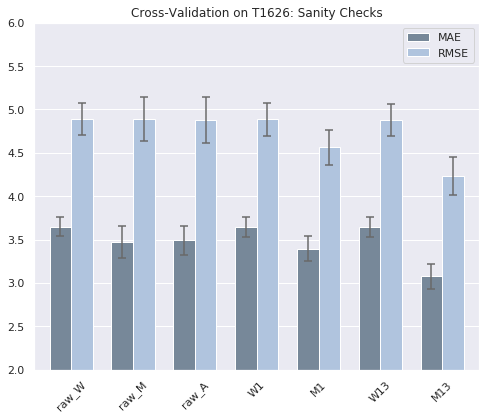

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Cross-Validation on T1626: Sanity Checks",saveloc=model_folder_loc+"sanity_checks_performance_NEW.png")

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)

In [0]:
results = results.round(3)
results

,MAE,RMSE,MAE_std,RMSE_std
raw_W,3.648,4.888,0.111,0.187
raw_M,3.472,4.891,0.182,0.258
raw_A,3.490,4.878,0.170,0.264
W1,3.647,4.885,0.115,0.189
M1,3.395,4.565,0.144,0.203
W13,3.643,4.882,0.114,0.186
M13,3.074,4.232,0.143,0.220


In [0]:
results.to_csv(model_folder_loc+"results_table_sanity_checks_NEW.csv")